# Run and process the prior monte carlo

Prior-based (or "unconstrained") Monte Carlo is a great but highly underused analysis.  It doesnt require much in terms of algorithmic controls and forces you to think about the Prior parameter distribution - both the mean vector (i.e. initial parameter values) and the prior parameter covariance matrix.  It also let's investigate model stability (across the prior range and also start to think critically about what observations the model will be able to match. 

The use of the multiplier parameter process allows us to easily generate a (semi-)meaningful Prior by using the existing model inputs as the mean vector and then using expected ranges and expected correlations (variograms) for the spatially-distributed inputs.  Sweet as!

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu
%matplotlib inline

## SUPER IMPORTANT: SET HOW MANY PARALLEL WORKERS TO USE

In [2]:
num_workers = 5

Load the model and visual to job your memory...

In [3]:
t_d = "template_history"
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=t_d,check=False,forgive=False)

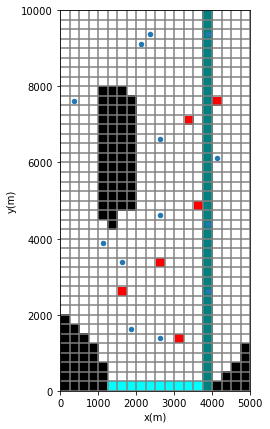

In [4]:
# plot some model attributes
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111,aspect="equal")
mm = flopy.plot.PlotMapView(model=m)
mm.plot_grid()
mm.plot_ibound()
mm.plot_bc('SFR')
mm.plot_bc("GHB")
ax = mm.ax
#m.wel.stress_period_data.plot(ax=ax,mflay=2)

# plot obs locations
obs = pd.read_csv(os.path.join("..","base_model_files","obs_loc.csv"))
                  
obs_x = [m.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [m.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.',label="water-level obs",s=80)

#plot names on the pumping well locations
wel_data = m.wel.stress_period_data[0]
wel_x = m.sr.xcentergrid[wel_data["i"],wel_data["j"]]
wel_y = m.sr.ycentergrid[wel_data["i"],wel_data["j"]]
for i,(x,y) in enumerate(zip(wel_x,wel_y)):
    ax.scatter([x],[y],color="red",marker="s",s=50)
    #ax.text(x,y,"{0}".format(i+1),ha="center",va="center")

ax.set_ylabel("y(m)")
ax.set_xlabel("x(m)")
plt.show()

read in the PEST control file that we constructed in the `setup_interface_notebook`

In [5]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.npar,pst.nobs

(11913, 7272)

Load the previously generated parameter ensemble and inspect (again!)...

In [6]:
pe = pyemu.ParameterEnsemble.from_binary(pst=pst,filename=os.path.join(t_d,"prior.jcb"))
#pe.loc[:,should_fix] = 1.0
pe.iloc[:50,:].to_csv(os.path.join(t_d,"sweep_in.csv"))
pe.shape

(300, 11913)

In [7]:
pe.loc[:,pst.par_names[0]]

0      1.928049
1      1.945557
2      0.429008
3      3.729993
4      2.692899
         ...   
295    0.522064
296    2.881931
297    0.857718
298    1.299828
299    3.941090
Name: const_hk6__cn, Length: 300, dtype: float64

<AxesSubplot:>

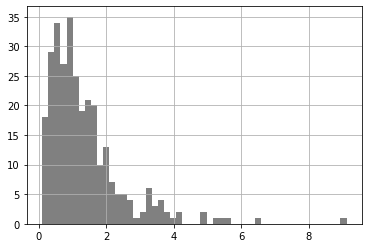

In [8]:
pe.loc[:,pst.par_names[0]].hist(bins=50,facecolor="0.5")

look! hk is log-normal-ish

Lets run the first realization through the pest interface for a test:

In [9]:
# replace the par vals with the first row in the par ensemble
pst.parameter_data.loc[pe.columns,"parval1"] = pe.iloc[0,:]
pst.control_data.noptmax = 0
pst.pestpp_options["overdue_giveup_fac"] = 1.5
# save the control file and execute!
pst.write(os.path.join(t_d,"test.pst"))
pyemu.os_utils.run("pestpp-ies test.pst",cwd=t_d)
res = pyemu.pst_utils.read_resfile(os.path.join(t_d,"test.base.rei"))
res.loc[pst.nnz_obs_names,:]

noptmax:0, npar_adj:11913, nnz_obs:350


,name,group,measured,modelled,residual,weight
name,,,,,,
fo_gage_1_20160101,fo_gage_1_20160101,fo_gage_1,7811.571739,9553.300000,-1741.728261,0.0015
fo_gage_1_20160201,fo_gage_1_20160201,fo_gage_1,8486.782129,14700.000000,-6213.217871,0.0015
fo_gage_1_20160301,fo_gage_1_20160301,fo_gage_1,9701.533827,15873.000000,-6171.466173,0.0015
fo_gage_1_20160401,fo_gage_1_20160401,fo_gage_1,9391.429930,15265.000000,-5873.570070,0.0015
fo_gage_1_20160501,fo_gage_1_20160501,fo_gage_1,7907.122907,13072.000000,-5164.877093,0.0015
...,...,...,...,...,...,...
trgw_034_010_20170901,trgw_034_010_20170901,trgw_034_010,33.931110,34.058300,-0.127190,3.0000
trgw_034_010_20171001,trgw_034_010_20171001,trgw_034_010,33.955884,34.023354,-0.067470,3.0000
trgw_034_010_20171101,trgw_034_010_20171101,trgw_034_010,33.985823,34.045910,-0.060087,3.0000


In [10]:
[f for f in os.listdir(t_d) if f.startswith("test")]

['test.base.par',
 'test.base.rei',
 'test.log',
 'test.obs.csv',
 'test.phi.actual.csv',
 'test.phi.composite.csv',
 'test.phi.group.csv',
 'test.phi.meas.csv',
 'test.phi.regul.csv',
 'test.pst',
 'test.rec']

Let's plot obs vs sim and see what we learned...

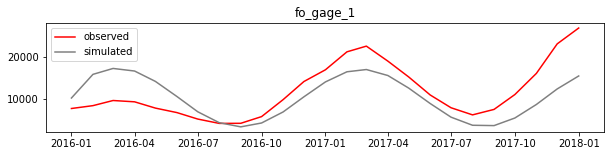

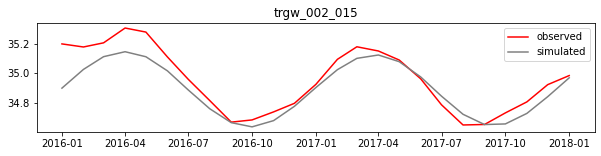

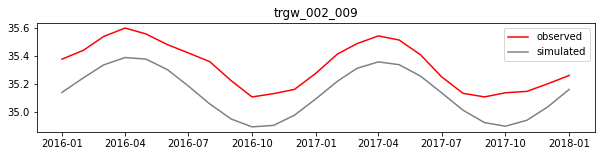

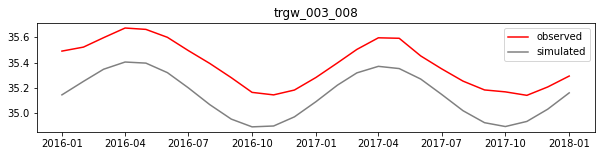

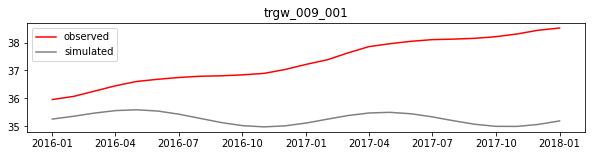

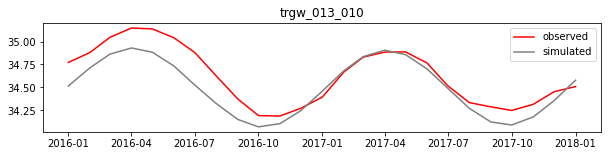

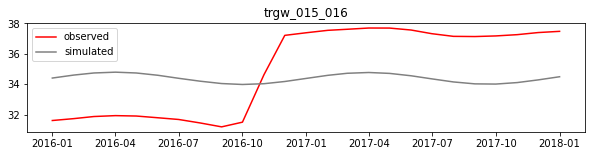

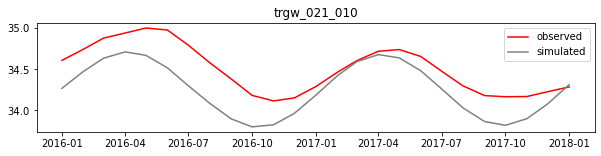

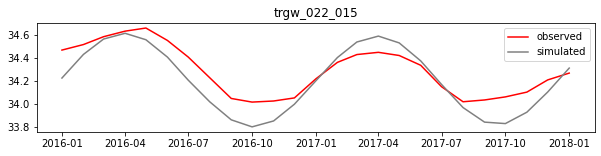

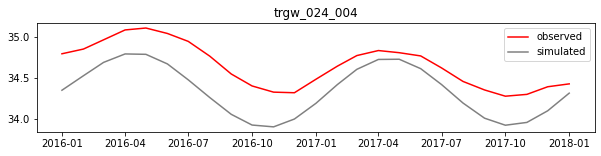

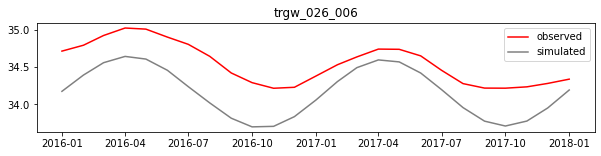

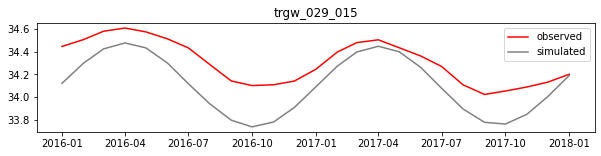

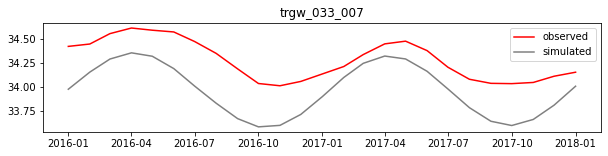

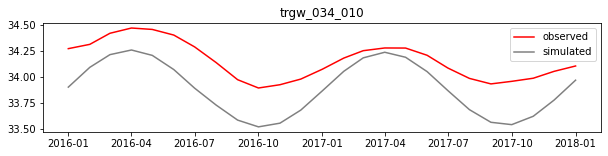

In [11]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))    
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    ax.plot(nz_obs_group.datetime,nz_obs_group.obsval,"r-",label="observed")
    ax.plot(nz_obs_group.datetime,pst.res.loc[nz_obs_group.obsnme,"modelled"],color="0.5",label="simulated")
    ax.set_title(nz_group)
    ax.legend()
plt.show()

Any comments here?  Did we learn anything about our model (or more importantly, the forecasts???)?

### run the prior ensemble in parallel locally
This takes advantage of the program `pestpp-swp` which runs a parameter sweep through a set of parameters in parallel using locally-avaible resources.  Remember that `num_workers` arg above?

By default, `pestpp-swp` reads in the ensemble from a file called `sweep_in.csv` which in this case we made just above.

In [12]:
m_d = "master_prior_sweep"
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.pestpp_options["overdue_giveup_fac"] = 5.0
pst.write(os.path.join(t_d,"freyberg_sweep.pst"))



noptmax:0, npar_adj:11913, nnz_obs:350


In [13]:
pyemu.os_utils.start_workers(t_d,"pestpp-swp","freyberg_sweep.pst",
                             num_workers=num_workers,worker_root=".",master_dir=m_d,)

Feel free to switch over to the terminal/command line to watch the progress...

### Load the output ensemble and plot a few things

by default, PESTPP-SWP writes the results of the parametric sweep to a csv file called `sweep_out.csv`.  This file has columns for each observation listed in the control file, plus columns for total phi and phi for each observation group (calculated using the weights in the control file).  It also has columns for the `input_run_id` and `failed_flag` to help you align these outputs with the inputs and also track any failed runs



In [14]:
obs_df = pd.read_csv(os.path.join(m_d,"sweep_out.csv"),index_col=0)
print('number of realization in the ensemble before dropping: ' + str(obs_df.shape[0]))

number of realization in the ensemble before dropping: 50


drop any failed runs 

In [15]:
obs_df = obs_df.loc[obs_df.failed_flag==0,:]
print('number of realization in the ensemble **after** dropping: ' + str(obs_df.shape[0]))

number of realization in the ensemble **after** dropping: 49


In [16]:
obs_df.iloc[0,:]

input_run_id                0.000000
failed_flag                 0.000000
phi                      5411.916885
meas_phi                 5411.916885
regul_phi                   0.000000
                            ...     
trgw_034_010_20171101      34.045910
trgw_034_010_20171201      34.089970
trgw_034_010_20180101      34.137398
part_status                 2.000000
part_time                 157.907549
Name: 0, Length: 7296, dtype: float64

Lets plot stochastic (ensemble-based) 1-to-1 plots

[<Figure size 576x756 with 0 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

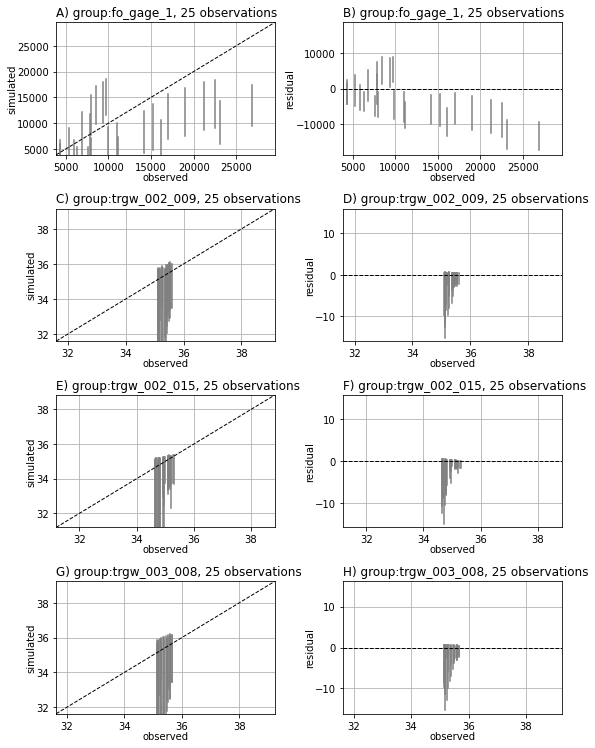

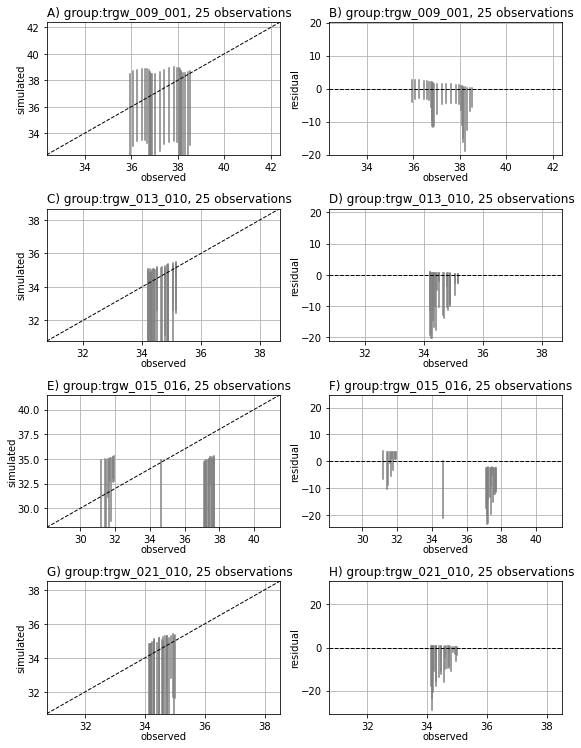

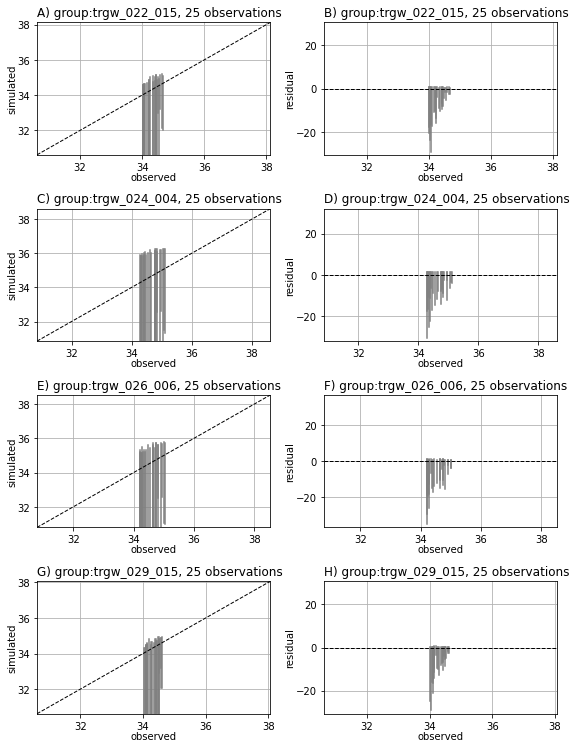

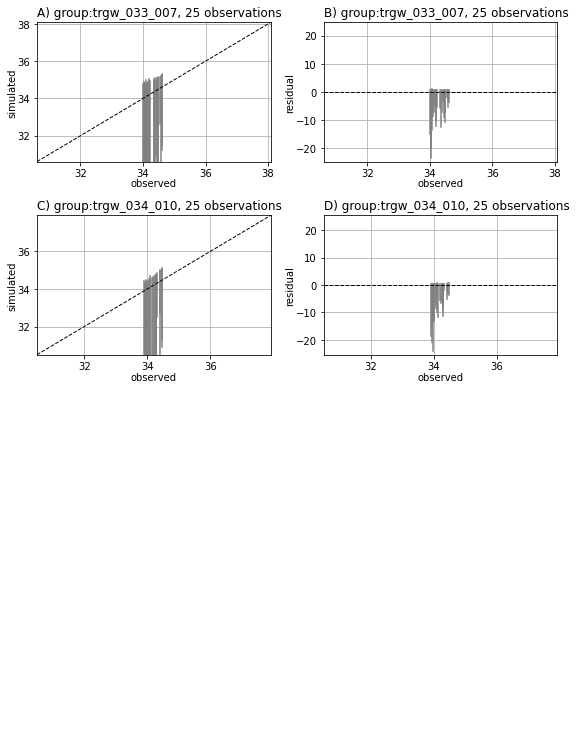

In [17]:
pyemu.plot_utils.ensemble_res_1to1(obs_df,pst)

### confirm which quantities were identified as forecasts

In [18]:
pst.forecast_names

['fa_hw_20171001',
 'fa_tw_20171001',
 'hds_00_013_002_021',
 'part_time',
 'part_status']

now we can plot the distributions of each forecast and also show the "truth" 

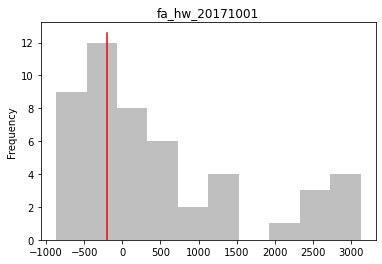

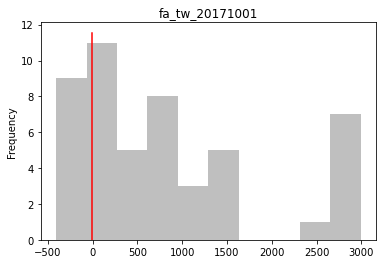

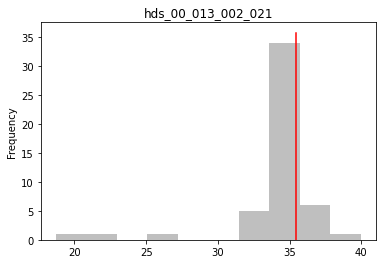

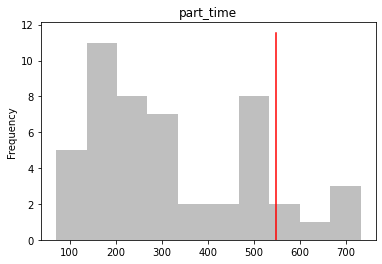

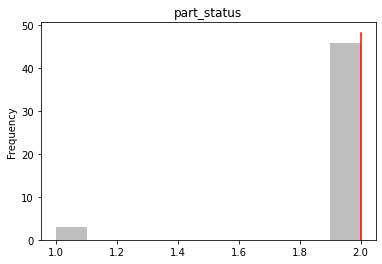

In [19]:
for forecast in pst.forecast_names:
    plt.figure()
    ax = obs_df.loc[:,forecast].plot(kind="hist",color="0.5",alpha=0.5)
    ax.set_title(forecast)
    fval = pst.observation_data.loc[forecast,"obsval"]
    ax.plot([fval,fval],ax.get_ylim(),"r-")

### Many modeling analyses could stop right here to avoid the ill-effects of history matching...

we see that for all forecasts, the prior forecast PDF covers the truth.  Are the uncertainty (e.g. variance) unacceptably wide? If not, your done!  If the variance is too large, then you might be able be justified in trying to reduce forecast uncertainty throught history matching if you have foreacst-sensitive data and if the model is amenable to assimilating these data...stay tuned!

### Some foreshadowing: let's also plot observed vs (stochastic) simulated:

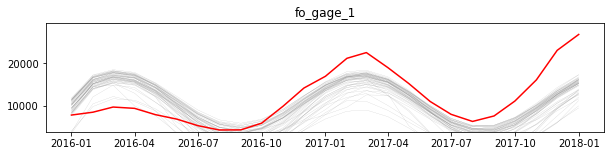

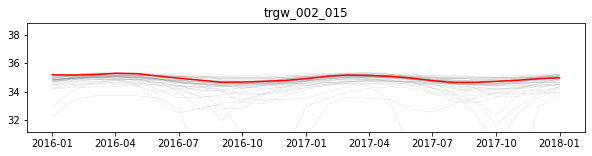

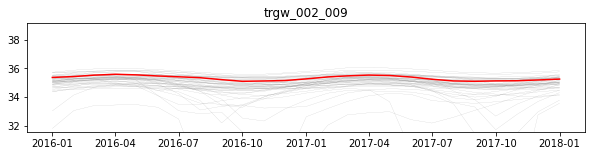

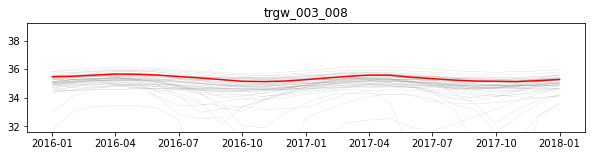

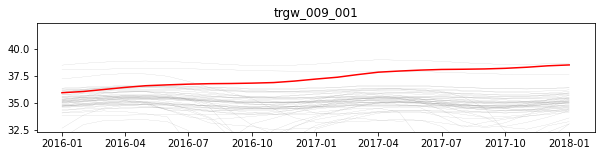

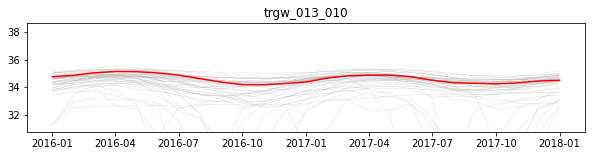

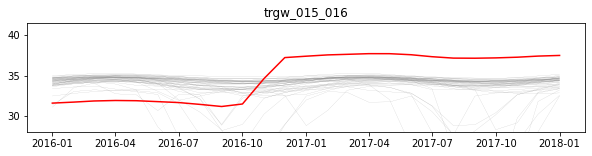

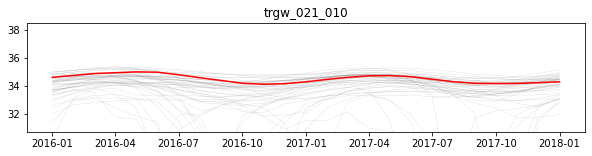

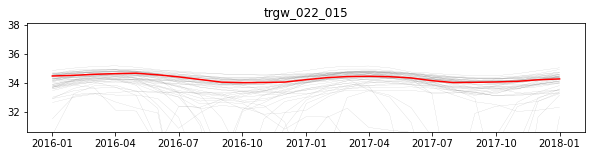

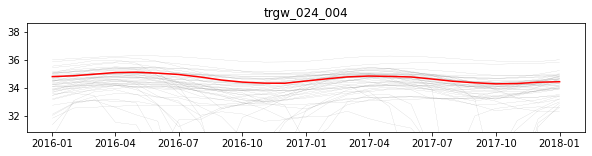

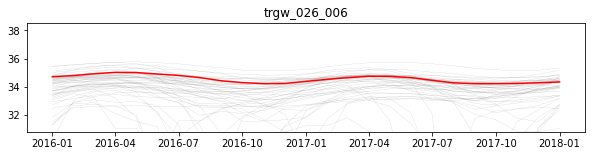

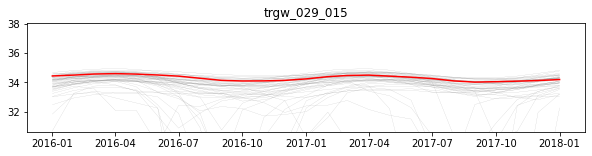

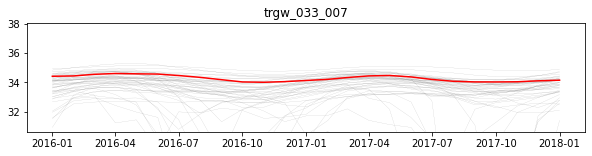

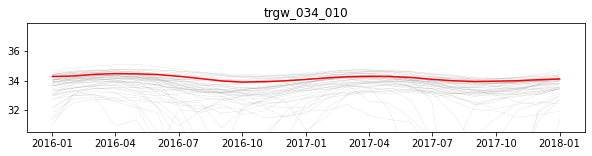

In [20]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))
pst_base = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    
    [ax.plot(nz_obs_group.datetime,obs_df.loc[r,nz_obs_group.obsnme],color="0.5",lw=0.1) for r in obs_df.index]
    #[ax.plot(nz_obs_group.datetime,oe_pt.loc[r,nz_obs_group.obsnme],color="b",lw=0.1,alpha=0.5) for r in oe_pt.index]
    ax.plot(nz_obs_group.datetime,nz_obs_group.obsval,"r-")
    #[ax.plot(nz_obs_group.datetime,oe_base.loc[r,nz_obs_group.obsnme],color="r",lw=0.1,alpha=0.5) for r in oe_base.index]
    
    ax.set_title(nz_group)
    #vmin = min(nz_obs_group.obsval.min(),oe_pt.loc[:,nz_obs_group.obsnme].min().min())
    #vmax = max(nz_obs_group.obsval.max(),oe_pt.loc[:,nz_obs_group.obsnme].max().max())
    vmin = nz_obs_group.obsval.min() * 0.9
    vmax = nz_obs_group.obsval.max() * 1.1
    ax.set_ylim(vmin,vmax)
plt.show()

[<Figure size 576x756 with 0 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>,
 <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

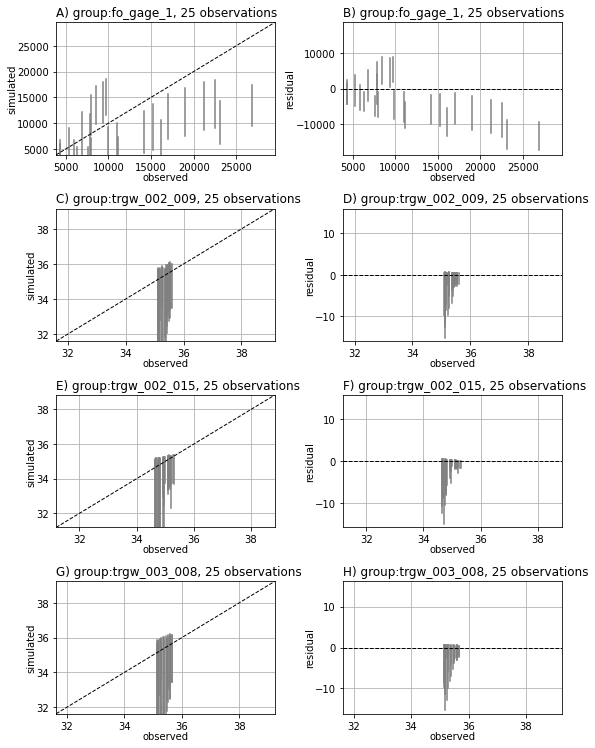

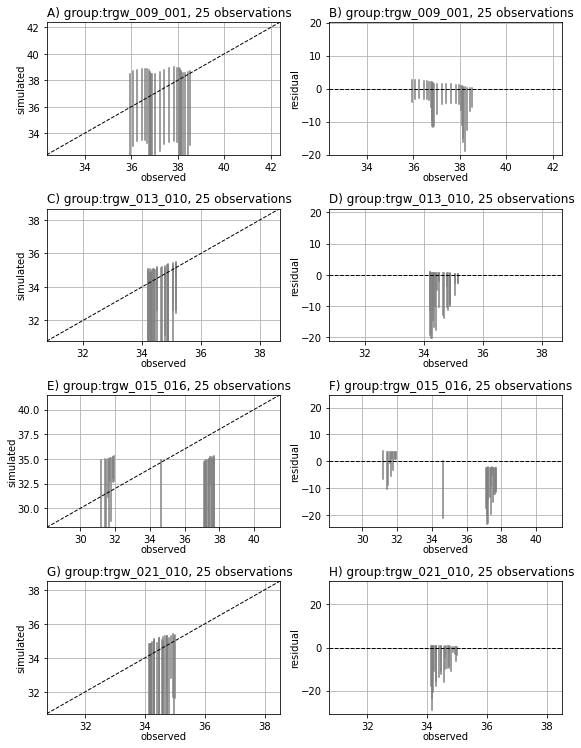

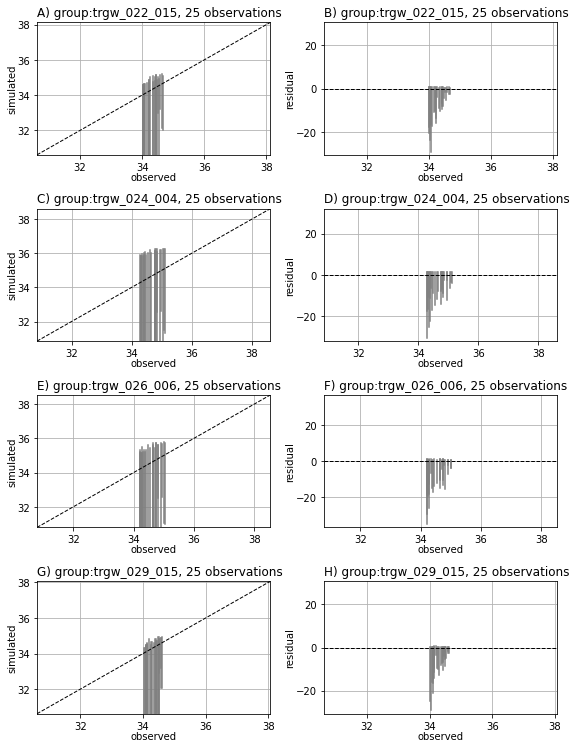

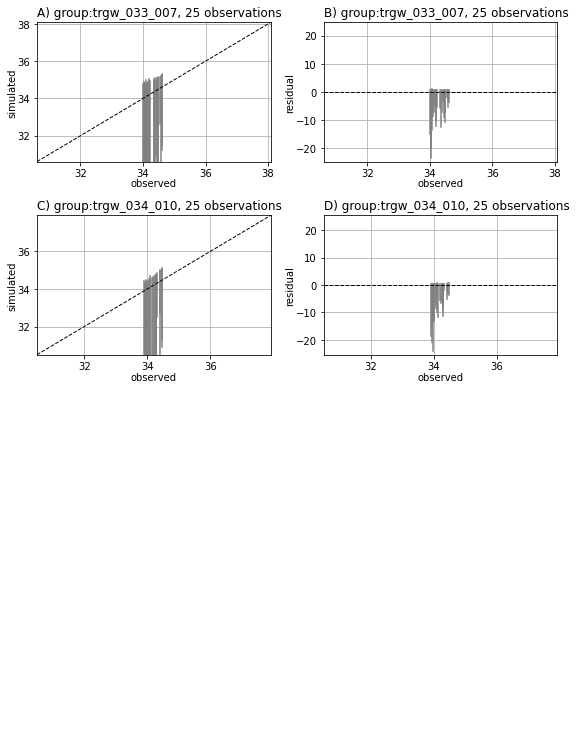

In [21]:
pyemu.plot.plot_utils.ensemble_res_1to1(obs_df,pst)

### Everything ok with these plots?  Any comments?

We are used to looking at obs vs sim for the single (deterministic case).  But visualizing obs vs sim from a prior Monte Carlo is far more valuable in terms of understanding what your model is doing and what is it capable of doing.

Conceptually, the prior ensemble shows the range of outputs the model yields using maximum expected parameter uncertainty (encapsulated in the Prior). So if this maximum range doesnt cover the observed value, how much parameter adjustment will it take to match these observations?  

### #dividends: Since we carried the final stress period sim water levels, we can now plot those just from the observation ensembles

When we move to an ensemble-based analysis, it is important to carry as many model outputs as possible in the PEST interface so that they are "recorded" during the ensemble evaluations.  Compared to deterministic analyses, the cost of getting new outputs is much higher...

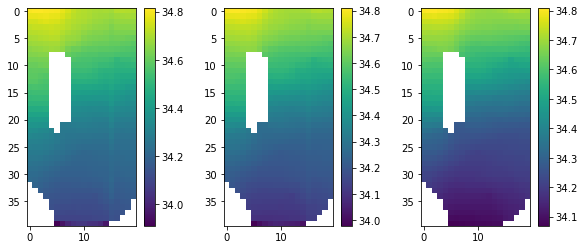

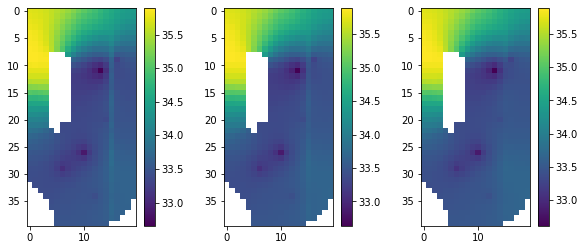

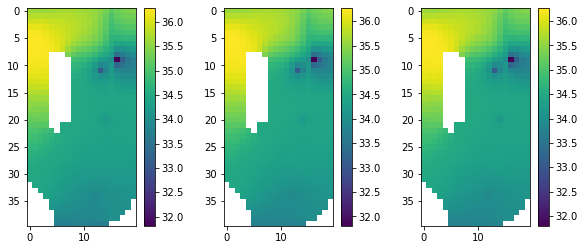

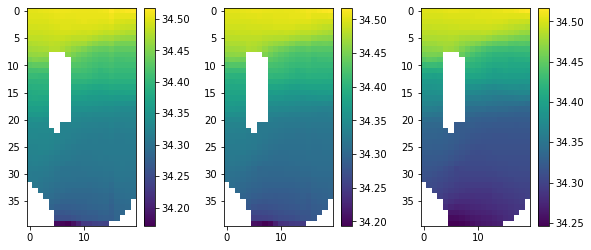

In [22]:
obs = pst.observation_data
hds_obs = obs.loc[obs.obsnme.apply(lambda x: x.startswith("hds_") and x.endswith("{0:03d}".format(m.nper-1))),:].copy()
hds_obs.loc[:,"i"] = hds_obs.obsnme.apply(lambda x: int(x.split('_')[2]))
hds_obs.loc[:,"j"] = hds_obs.obsnme.apply(lambda x: int(x.split('_')[3]))
hds_obs.loc[:,"k"] = hds_obs.obsnme.apply(lambda x: int(x.split('_')[1]))

ib = m.bas6.ibound.array
def plot_real(real):
    pr_arr = np.zeros((m.nlay,m.nrow,m.ncol))
    pr_arr[hds_obs.k,hds_obs.i,hds_obs.j] = obs_df.loc[real,hds_obs.obsnme]
    pr_arr[ib==0] = np.NaN
    #vmin = obs_df.loc[:,hds_obs.obsnme].min().min()
    #vmax = obs_df.loc[:,hds_obs.obsnme].max().max()
    
    fig,axes = plt.subplots(1,3,figsize=(10,4))
    for k in range(m.nlay):
        cb = axes[k].imshow(pr_arr[k,:,:])
        plt.colorbar(cb,ax=axes[k])
    plt.show()
plot_real(obs_df.index[0])
plot_real(obs_df.index[1])
plot_real(obs_df.index[2])
plot_real(obs_df.index[3])

### Run prior Monte Carlo with a diagonal prior parameter covariance matrix

We can also do a cheap Monte Carlo analysis using PESTPP-IES.  When `noptmax` is set to -1, PESTPP-IES runs a prior monte carlo and quits.  By default, PESTPP-IES uses 50 realizations so we can just fire it up!

In [23]:
pst.pestpp_options

{'forecasts': 'fa_hw_20171001,fa_tw_20171001,hds_00_013_002_021,part_time,part_status',
 'overdue_giveup_fac': 5.0}

In [24]:
pst.control_data.noptmax = -1
pst.write(os.path.join(t_d,"freyberg_diagprior.pst"))

noptmax:-1, npar_adj:11913, nnz_obs:350


In [25]:
m_d = "master_diagonal_prior_monte_carlo" 

In [26]:
pyemu.os_utils.start_workers(t_d,"pestpp-ies","freyberg_diagprior.pst",num_workers=num_workers,
                             master_dir=m_d)

In [27]:
obs_df = pd.read_csv(os.path.join(m_d,"freyberg_diagprior.0.obs.csv"),index_col=0)

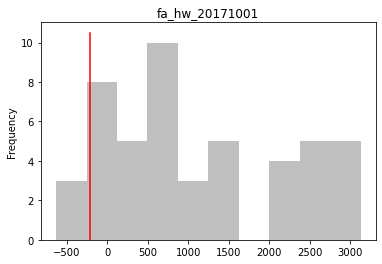

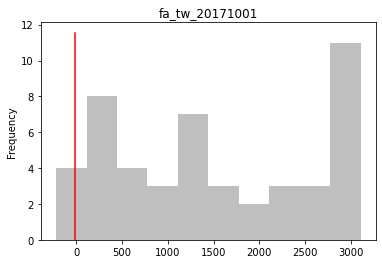

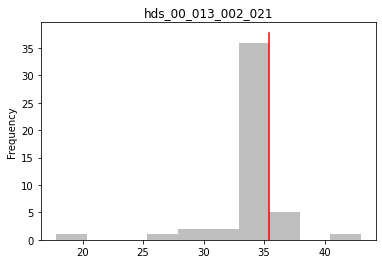

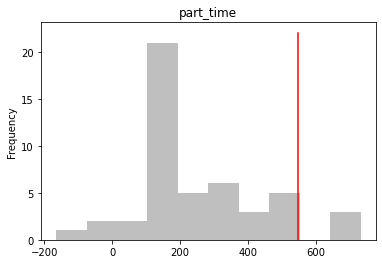

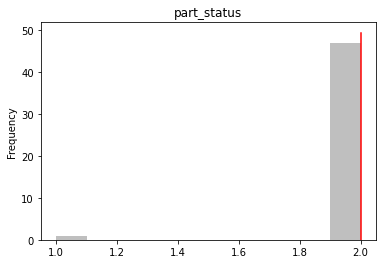

In [28]:
for forecast in pst.forecast_names:
    plt.figure()
    ax = obs_df.loc[:,forecast].plot(kind="hist",color="0.5",alpha=0.5)
    ax.set_title(forecast)
    fval = pst.observation_data.loc[forecast,"obsval"]
    ax.plot([fval,fval],ax.get_ylim(),"r-")

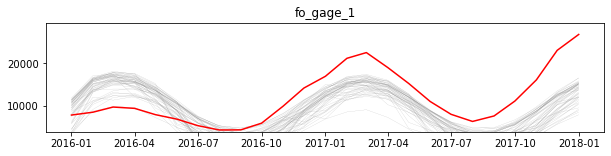

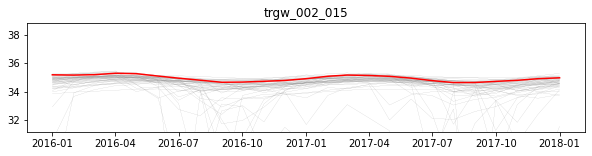

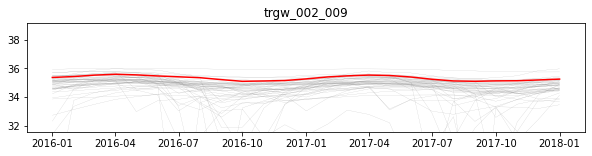

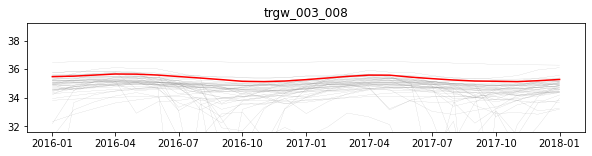

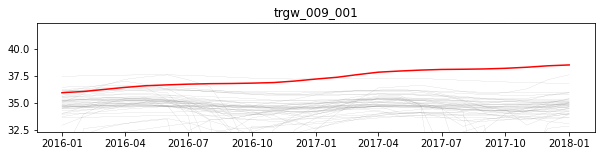

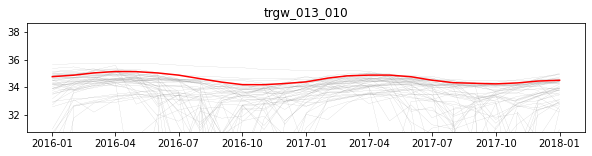

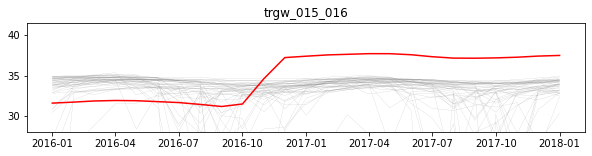

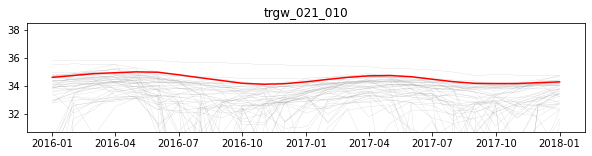

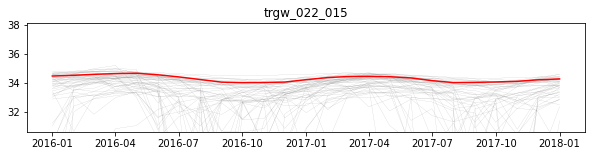

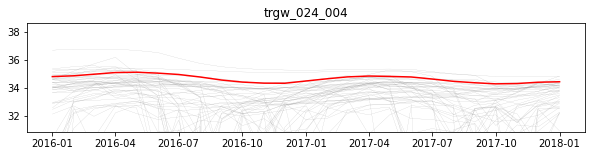

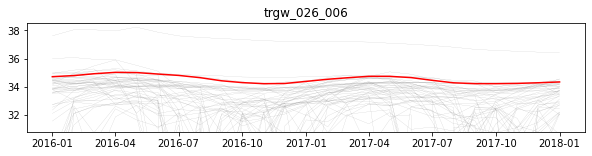

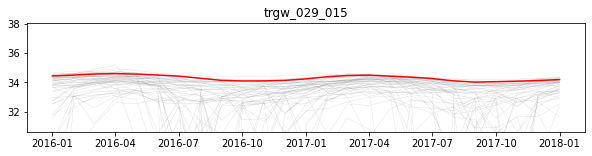

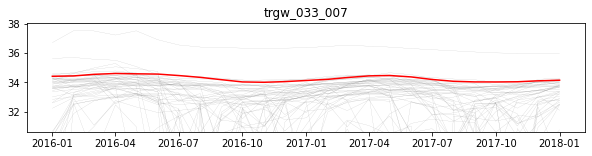

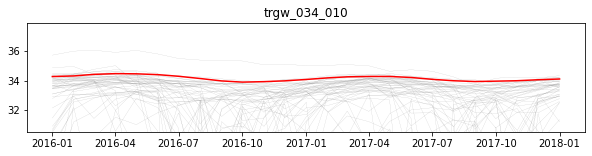

In [29]:
nz_obs = pst.observation_data.loc[pst.nnz_obs_names,:].copy()
nz_obs.loc[:,"datetime"] = pd.to_datetime(nz_obs.obsnme.apply(lambda x: x.split("_")[-1]))
pst_base = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
for nz_group in pst.nnz_obs_groups:
    nz_obs_group = nz_obs.loc[nz_obs.obgnme==nz_group,:]
    fig,ax = plt.subplots(1,1,figsize=(10,2))
    
    [ax.plot(nz_obs_group.datetime,obs_df.loc[r,nz_obs_group.obsnme],color="0.5",lw=0.1) for r in obs_df.index]
    #[ax.plot(nz_obs_group.datetime,oe_pt.loc[r,nz_obs_group.obsnme],color="b",lw=0.1,alpha=0.5) for r in oe_pt.index]
    ax.plot(nz_obs_group.datetime,nz_obs_group.obsval,"r-")
    #[ax.plot(nz_obs_group.datetime,oe_base.loc[r,nz_obs_group.obsnme],color="r",lw=0.1,alpha=0.5) for r in oe_base.index]
    
    ax.set_title(nz_group)
    #vmin = min(nz_obs_group.obsval.min(),oe_pt.loc[:,nz_obs_group.obsnme].min().min())
    #vmax = max(nz_obs_group.obsval.max(),oe_pt.loc[:,nz_obs_group.obsnme].max().max())
    vmin = nz_obs_group.obsval.min() * 0.9
    vmax = nz_obs_group.obsval.max() * 1.1
    ax.set_ylim(vmin,vmax)
plt.show()